# Imports

In [2]:
import torch
from torch.utils.data import Dataset
from torch.utils.data import DataLoader
from torchvision.datasets.folder import default_loader
import torchvision.transforms as T
import os
from torch.utils.data import random_split
from PIL import Image
import pandas as pd
import numpy as np
import glob
from torch import optim
from tqdm import tqdm, notebook # This is optional but useful
from torchvision import datasets
import matplotlib.pyplot as plt
import torch
from torch import nn

# Dataset

In [3]:
class Traffic(Dataset):
  def __init__(self, root_dir, transform=None, loader=default_loader):
    
    self.image_paths, self.labels = self._get_imgs_and_labels(root_dir)
    
    self.transform = transform
    self.loader = loader
    
  def __len__(self):
    return len(self.labels)
  
  def __getitem__(self, index):
    image = self.loader(self.image_paths[index])
    label = self.labels[index]

    if self.transform:
      image = self.transform(image)
  
    return image, torch.tensor(int(label)-1) # Convert labels to tensors, and subtract 1 for convention purposes (to start at 0)
  
  # Helper Functions
  def print_image(self, index):
    img = Image.open(self.image_paths[index])
    img.show()
    print(self.labels[index])

  def _get_imgs_and_labels(self, root_dir):
    image_full_path = []
    labels = []
    
    # Get paths to each image (in order)
    for img_path in sorted(glob.glob(os.path.join(root_dir, "images", "*.jpg"))):
      image_full_path.append(img_path)
    
    # Get labels
    with open(os.path.join(root_dir, "annotations.txt"), 'r') as f:
      for label in f:
        labels.append(int(label.strip()) + 1)
    
    return image_full_path, labels

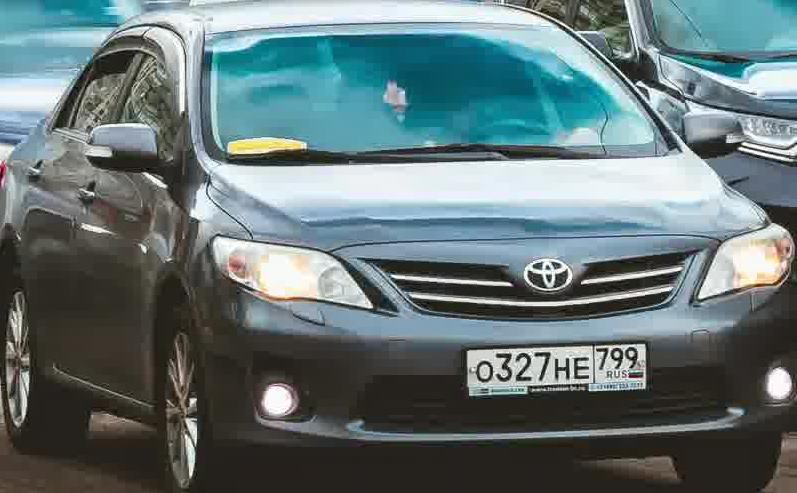

1


In [4]:
data_dir = "Traffic_Processed"

data = Traffic(root_dir=data_dir, transform=T.ToTensor())

data.print_image(3)

# Network

In [5]:
class Convolutional(nn.Module):
  def __init__(self, in_channels=3):
    super().__init__()
    self.conv = nn.Sequential(nn.Conv2d(3, 32, kernel_size=3, padding=1, stride=1),
                              nn.ReLU(),
                              nn.MaxPool2d(kernel_size=2, stride=2),
                              
                              nn.Conv2d(32, 64, kernel_size=3, padding=1, stride=1),
                              nn.ReLU(),
                              nn.MaxPool2d(kernel_size=2, stride=2),
                              
                              nn.Conv2d(64, 128, kernel_size=3, padding=1, stride=1),
                              nn.ReLU(),
                              nn.MaxPool2d(kernel_size=2, stride=2),                                                                 
    )
    self.linear = nn.Sequential(nn.Dropout(p=0.5),
                                nn.Linear(in_features=100352, out_features=4608),
                                nn.ReLU(),
                                nn.Dropout(p=0.5),
                                nn.Linear(in_features=4608, out_features=7),
                                # nn.Softmax(dim=1)
                                )
  
  def forward(self, x):
    x = self.conv(x)
    b, c, h, w = x.shape
    x = x.view(b, -1) # Flatten image
    x = self.linear(x)
    
    return x

# Data Processing

2441
3488
Type: <class 'list'>
Length: 2
More Types: <class 'torch.Tensor'>, <class 'torch.Tensor'>
Shapes: torch.Size([32, 3, 224, 224]), torch.Size([32])
Labels: tensor([1, 0, 0, 2, 0, 0, 0, 0, 0, 3, 0, 5, 0, 1, 0, 0, 0, 4, 5, 0, 2, 0, 0, 0,
        0, 0, 0, 0, 1, 0, 0, 1])

tensor(1)
tensor(0)
tensor(0)


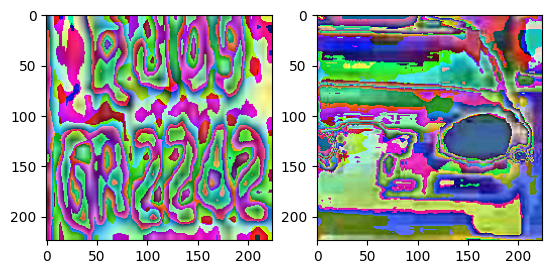

In [6]:
data_dir = "./Traffic_Processed"

transform = T.Compose ([
  T.Resize((224, 224)),
  T.ToTensor(),
  T.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])

vehicle_data = Traffic(root_dir=data_dir, transform=transform)

train_data_size = int(len(vehicle_data) * .75) 
validation_data_size = int(len(vehicle_data) * .1)

print(train_data_size + validation_data_size)
print(len(vehicle_data))
test_data_size = len(vehicle_data) - (train_data_size + validation_data_size)

train_data, val_data, test_data = random_split(vehicle_data, [train_data_size, validation_data_size, test_data_size])

train = DataLoader(vehicle_data, batch_size=32, shuffle=True)

data = iter(train) # Let's iterate on it
single_point = next(data)
print(f"""Type: {type(single_point)}
Length: {len(single_point)}
More Types: {type(single_point[0])}, {type(single_point[1])}
Shapes: {single_point[0].shape}, {single_point[1].shape}
Labels: {single_point[1]}
""")

print(single_point[1][0])
print(single_point[1][1])
print(single_point[1][2])

import matplotlib.pyplot as plt
from torchvision import transforms as T
ToPIL = T.ToPILImage() # Converting function
img0 = ToPIL(single_point[0][0])
img1 = ToPIL(single_point[0][1])
# Plotting
fig, axs = plt.subplots(1,2)
axs[0].imshow(img0)
axs[1].imshow(img1)

# Training

In [7]:
loss_history = []
acc_history = []
val_loss_history = []
val_acc_history = []


def train_model(optimizer,model,device,scheduler,nepochs,LossFunction,batch_size):
    
    train_dataloader = DataLoader(train_data,batch_size=batch_size)
    val_dataloader = DataLoader(val_data,batch_size=batch_size)
    
    best_accuracy = 0
    
    # This is default on but let's just be pedantic
    model.train()
    loss = torch.Tensor([0])
    correct = 0
    total = 0
    for epoch in tqdm(range(nepochs),
                    desc=f"Epoch",
                    unit="epoch",
                    disable=False):
        train_loss = 0
        val_loss = 0
        for (data, label) in tqdm(train_dataloader,
                                desc="iteration",
                                unit="%",
                                disable=True):
            optimizer.zero_grad(set_to_none=True) # Here we clear the gradients
            
            # We need to make sure the tensors are on the same device as our model
            data = data.to(device)
            label = label.to(device)
            out = model(data)
            
            loss = LossFunction(out, label)
            loss.backward() # Calculate Gradients
            optimizer.step() # Gradient Descent
            
            # Get accuracy for this iteration
            _, predicted = torch.max(out.data, 1)
            total += label.size(0)
            correct += (predicted == label).sum().item()
        
        # Calculate accuracy for the epoch on training data    
        train_accuracy = 100 * correct / total
        acc_history.append(train_accuracy)
        train_loss = loss.item()
        loss_history.append(train_loss)
        
        # Validation
        model.eval() # No longer training - comparing loss and accuracy in our validation set
        correct = 0
        total = 0
        with torch.no_grad():
            for (data, label) in val_dataloader:
                data = data.to(device)
                label = label.to(device)
                out = model(data)
                loss = LossFunction(out, label)

                # Get accuracy for this iteration  
                _, predicted = torch.max(out.data, 1)
                total += label.size(0)
                correct += (predicted == label).sum().item()
            
            # Calculate accuracy for the epoch on training data     
            val_accuracy = 100 * correct / total
            
            # Check if this is the best validation accuracy - want to save this model
            if (val_accuracy > best_accuracy):
                torch.save(model.state_dict(), "best_model.pth")
                best_accuracy = val_accuracy

            val_acc_history.append(val_accuracy)
            val_loss = loss.item()
            val_loss_history.append(val_loss)
            
        if (scheduler):
            scheduler.step()  
            
        last_lr = scheduler.get_last_lr()[0] if scheduler else optimizer.param_groups[0]['lr']
        print(f"Epoch {epoch+1}/{nepochs}, Train Loss: {train_loss:.4f}, Train Acc: {train_accuracy:.4f}, "
            f"Valid Loss: {val_loss:.4f}, Valid Acc: {val_accuracy:.4f}, Learning Rate: {last_lr:.6f}")
          

def set_hyper_and_run(nepochs,LossFunction,batch_size,model,learning_rate,device, SGD=True):
    if SGD:
        optimizer = optim.SGD(model.parameters(), lr=learning_rate)
    else:
        # need to change learning rate to get Adam to converge
        optimizer = optim.Adam(model.parameters(), lr=learning_rate,weight_decay=.2)
    # scheduler = optim.lr_scheduler.MultiStepLR(optimizer,milestones=[2,4],gamma=0.4)
    scheduler = None
    print(model)
    train_model(optimizer=optimizer,model=model,device=device,scheduler=scheduler,nepochs=nepochs,LossFunction=LossFunction,batch_size=batch_size)


In [8]:
if torch.cuda.is_available():
    device = torch.device("cpu")
    print("Using GPU:", torch.cuda.get_device_name(0))
else:
    device = torch.device("cpu")
    print("Using CPU")

nepochs = 10
LossFunction = nn.CrossEntropyLoss()  
batch_size = 32
model = Convolutional().to(device)
lr = .01
optimizer = optim.SGD(model.parameters(), lr=lr)


set_hyper_and_run(nepochs, LossFunction, batch_size, model, lr, device)

Using GPU: NVIDIA GeForce RTX 2070 SUPER
Convolutional(
  (conv): Sequential(
    (0): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (1): ReLU()
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (4): ReLU()
    (5): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (6): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
    (7): ReLU()
    (8): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  )
  (linear): Sequential(
    (0): Dropout(p=0.5, inplace=False)
    (1): Linear(in_features=100352, out_features=4608, bias=True)
    (2): ReLU()
    (3): Dropout(p=0.5, inplace=False)
    (4): Linear(in_features=4608, out_features=7, bias=True)
  )
)


Epoch:  10%|█         | 1/10 [01:50<16:38, 110.92s/epoch]

Epoch 1/10, Train Loss: 1.0309, Train Acc: 54.0711, Valid Loss: 0.9754, Valid Acc: 57.9627, Learning Rate: 0.010000


Epoch:  20%|██        | 2/10 [03:36<14:20, 107.59s/epoch]

Epoch 2/10, Train Loss: 0.7170, Train Acc: 60.6309, Valid Loss: 0.8409, Valid Acc: 62.5538, Learning Rate: 0.010000


Epoch:  30%|███       | 3/10 [05:18<12:16, 105.18s/epoch]

Epoch 3/10, Train Loss: 0.5299, Train Acc: 66.0385, Valid Loss: 0.7490, Valid Acc: 66.4275, Learning Rate: 0.010000


Epoch:  40%|████      | 4/10 [07:01<10:25, 104.18s/epoch]

Epoch 4/10, Train Loss: 0.3710, Train Acc: 69.9304, Valid Loss: 0.6679, Valid Acc: 68.2927, Learning Rate: 0.010000


Epoch:  50%|█████     | 5/10 [08:43<08:37, 103.51s/epoch]

Epoch 5/10, Train Loss: 0.2291, Train Acc: 73.3716, Valid Loss: 0.5864, Valid Acc: 71.0187, Learning Rate: 0.010000


Epoch:  60%|██████    | 6/10 [10:25<06:51, 102.96s/epoch]

Epoch 6/10, Train Loss: 0.1146, Train Acc: 77.3044, Valid Loss: 0.5377, Valid Acc: 73.8881, Learning Rate: 0.010000


Epoch:  70%|███████   | 7/10 [12:07<05:08, 102.69s/epoch]

Epoch 7/10, Train Loss: 0.0775, Train Acc: 80.5817, Valid Loss: 0.4857, Valid Acc: 76.0402, Learning Rate: 0.010000


Epoch:  80%|████████  | 8/10 [13:48<03:24, 102.25s/epoch]

Epoch 8/10, Train Loss: 0.0462, Train Acc: 84.2278, Valid Loss: 0.4483, Valid Acc: 78.0488, Learning Rate: 0.010000


Epoch:  90%|█████████ | 9/10 [15:30<01:42, 102.18s/epoch]

Epoch 9/10, Train Loss: 0.0330, Train Acc: 85.8255, Valid Loss: 0.4364, Valid Acc: 78.6227, Learning Rate: 0.010000


Epoch: 100%|██████████| 10/10 [17:13<00:00, 103.31s/epoch]

Epoch 10/10, Train Loss: 0.0182, Train Acc: 89.1438, Valid Loss: 0.3325, Valid Acc: 79.7704, Learning Rate: 0.010000


In [11]:
model.eval()
accuracy = 0
total = 0
total2 = 0

test = DataLoader(test_data, batch_size=32, shuffle=True)

for (data, label) in test:
    data = data.to(device)
    label = label.to(device)
    out = model(data)
    answers = out.max(dim=1)[1]
    accuracy += (answers == label).sum(0)
    
print(f"Total accuracy = {accuracy / test_data_size*100:.2f}%")

Total accuracy = 76.60%


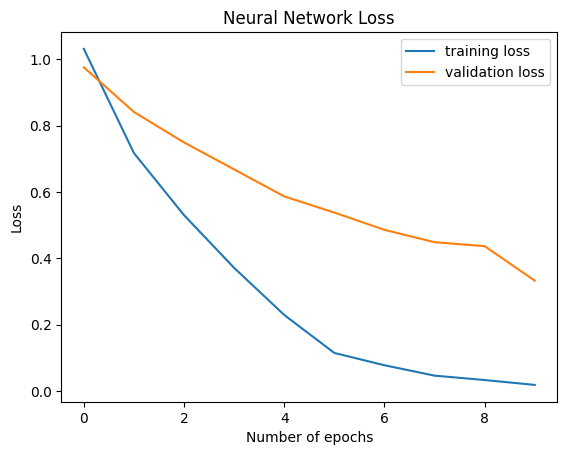

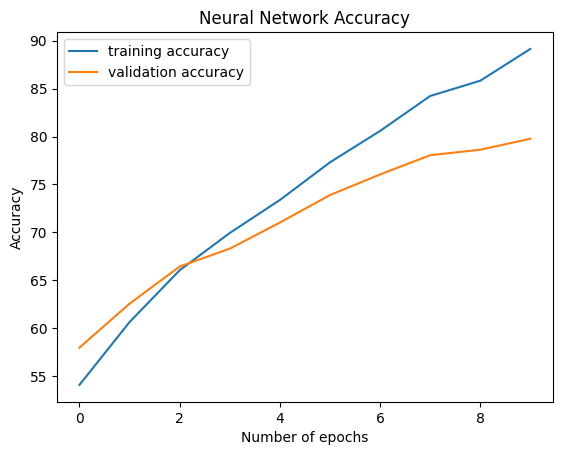

In [12]:
plt.plot(loss_history, label='training loss')
plt.plot(val_loss_history, label='validation loss')
plt.title("Neural Network Loss")
plt.xlabel("Number of epochs")
plt.ylabel("Loss")
plt.legend()
plt.show()

plt.plot(acc_history, label='training accuracy')
plt.plot(val_acc_history, label='validation accuracy')
plt.title("Neural Network Accuracy")
plt.xlabel("Number of epochs")
plt.ylabel("Accuracy")
plt.legend()
plt.show()  